In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import mglearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [29]:
x, y = datasets.make_blobs(random_state=0)
x_train, x_test, y_train, y_test = train_test_split(x, y)

logreg = LogisticRegression(solver="lbfgs", multi_class="auto").fit(x_train, y_train)
print(f"Test set score: {logreg.score(x_test, y_test):.2f}")

Test set score: 0.96


モデルの評価とパラメータの選択を扱う。

# 交差検証
汎化性能を評価する方法としてデータの訓練/テストデータの分割を変え複数回モデルを訓練する **交差検証** がある。これは、モデル評価において訓練データとテストデータを単純分割するよりも結果が安定する。結果は複数出力され、スコアの平均値からは汎化性能、ばらつきからはモデルの訓練データへの敏感さを知ることができる。ただ、訓練コストは増える。

In [30]:
from sklearn.model_selection import cross_val_score

iris = datasets.load_iris()
logreg = LogisticRegression(solver="lbfgs", multi_class="auto", max_iter=150)

# 交差検証を3分割で行う (cvで分割数を指定)
scores = cross_val_score(logreg, iris.data, iris.target, cv=3)
scores = np.round(scores, 3)

print(f"Cross-validation scores: {scores}")

Cross-validation scores: [0.98  0.941 1.   ]


scikit-learnではモデルの種類毎に以下のアルゴリズムが使用される。

* 回帰モデル: k分割交差検証
* 分類モデル: 層化k分割交差検証

## k分割交差検証
データをk個に分割し、1個を評価用とし他を訓練用で学習をさせるのをk回、毎回違う評価用で行う。

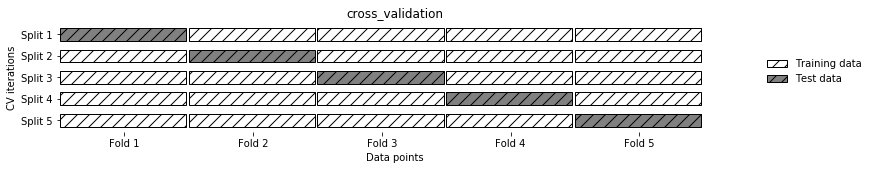

In [31]:
mglearn.plots.plot_cross_validation()

## 層化k分割交差検証
訓練データは並び順によっては分割後の訓練データに偏りが生じる。これを避け、分割後の訓練データのクラス比率が全体と同じする分割方法もある。下記図ではk分割交差検証の1番目に対し、2番目が層化k分割交差検証になっている。

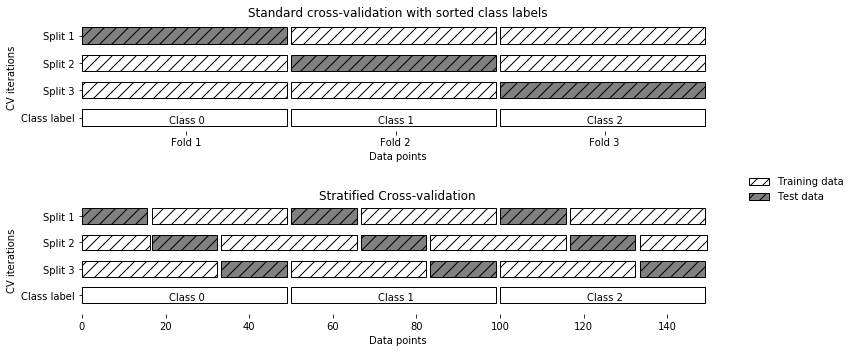

In [32]:
mglearn.plots.plot_stratified_cross_validation()

## 1つ抜き交差検証
テストデータを1サンプル取り出し検証する **1つ抜き交差検証** がある。大規模データセットでは時間が掛かるが、小さいデータセットに対しては良い推定ができる。

In [33]:
from sklearn.model_selection import LeaveOneOut

# 交差検証を3分割で行う (cvで分割数を指定)
loo = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target, cv=loo)

print(f"Cross-validation scores: {scores}")

Cross-validation scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


## シャッフル分割交差検証
毎回訓練データ(train_size個)、テストデータ(test_size個)取り出して訓練・評価をn_iter回繰り返す。浮動小数点を使用してデータ全体に対する割合で指定することも可能。

In [34]:
from sklearn.model_selection import ShuffleSplit

# 交差検証を3分割で行う (cvで分割数を指定)
ss = ShuffleSplit(n_splits=10, test_size=0.5, train_size=0.5)
scores = cross_val_score(logreg, iris.data, iris.target, cv=ss)
scores = np.round(scores, 3)

print(f"Cross-validation scores: {scores}")

Cross-validation scores: [0.947 0.973 0.973 0.96  0.933 0.96  0.973 0.947 0.973 0.987]


## グループ付き交差検証
異なる分割間で跨ってほしくないデータを指定したい場合もある。例えば、顔から表情を訓練する場合、推論したいのは未知の顔の表情であるため訓練用とテスト用のデータで同一人物が入るのは汎化性能を上げる点で良くない。これは GroupKFoldで実現できる。

In [35]:
from sklearn.model_selection import GroupKFold

x, y = datasets.make_blobs(12, random_state=0)
groups = [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3]

# 交差検証を3分割で行う (cvで分割数を指定)
gkf = GroupKFold(n_splits=3)
scores = cross_val_score(logreg, x, y, groups, cv=gkf)
scores = np.round(scores, 3)

print(f"Cross-validation scores: {scores}")

Cross-validation scores: [0.75  0.6   0.667]


上記のコードでは以下のグルーピングが行われる。

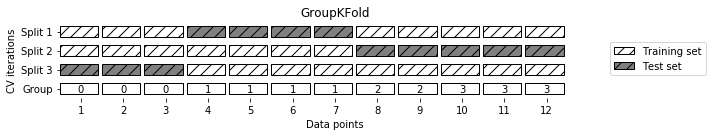

In [36]:
mglearn.plots.plot_group_kfold()

# グリッドサーチ
モデルの性能を最大化するハイパーパラメータを見つけるのは難しい作業だが、scikit-learnにはこの作業を支援する **GridSearchCV** が提供されている。これを使うと、以下処理を行った学習器として使える。

* コンストラクタでハイパーパラメータの値リストと学習器を渡す
* ハイパーパラメータの値リスト全ての組み合わせで訓練
* 交差検証し、最良スコアを出すハイパーパラメータを選択
* 全データで改めて訓練を行う


In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

# 調整させるパラメータはハイパーパラメータ毎に値をリストとして持つ辞書
param_grid = { "C": [0.001, 0.01, 0.1, 1, 10, 100], "gamma": [0.001, 0.01, 0.1, 1, 10, 100] }

# fitで訓練データを更にパラメータの調整と検証用に分割、交差検証が行われる
grid_search = GridSearchCV(SVC(), param_grid, cv=5, iid=False)
grid_search.return_train_score = False
grid_search.fit(x_train, y_train)

# 訓練データに対するスコア
# その他、best_*で最終的な学習器やハイパーパラメータを得られる
print(f"Training Data Score: {grid_search.best_score_}")

# テストデータに対するスコア
print(f"Test Data Score: {grid_search.score(x_test, y_test)}")

Training Data Score: 0.9726896292113683
Test Data Score: 0.9736842105263158


In [38]:
# 訓練結果はcv_results_で確認できる。各行にハイパーパラメータでのスコアが入っている
cv_result = pd.DataFrame(grid_search.cv_results_)
header = cv_result.columns.sort_values()
cv_result.loc[:2, header]

,mean_fit_time,mean_score_time,mean_test_score,param_C,param_gamma,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_fit_time,std_score_time,std_test_score
0,0.000587,0.000298,0.36621,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",22,0.375,0.347826,0.363636,0.363636,0.380952,1.920989e-04,0.000243,0.011365
1,0.000496,0.000104,0.36621,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",22,0.375,0.347826,0.363636,0.363636,0.380952,6.217196e-07,0.000208,0.011365
2,0.000487,0.000202,0.36621,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",22,0.375,0.347826,0.363636,0.363636,0.380952,1.387785e-05,0.000247,0.011365


# 評価水準とスコア

## TP/TF/FP/FN
陽性・陰性の他に2種。偏ったデータセットでは重要となる。データの9割が陽性ならば全てを陽性としても正解率9割を達成できてしまう。

* 偽陽性: タイプ1エラー
* 偽陰性: タイプ2エラー

In [39]:
digits = datasets.load_digits()
y = digits.target == 9
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=0)

In [40]:
from sklearn.dummy import DummyClassifier

# 常に最多の結果を返す分類器
dummy_majority = DummyClassifier(strategy="stratified").fit(X_train, y_train)
pred_dummy = dummy_majority.predict(X_test)
print("Test score: {:.2f}".format(dummy_majority.score(X_test, y_test)))

Test score: 0.80


dummy: 
[[366  37]
 [ 43   4]]
logreg: 
[[402   1]
 [  6  41]]


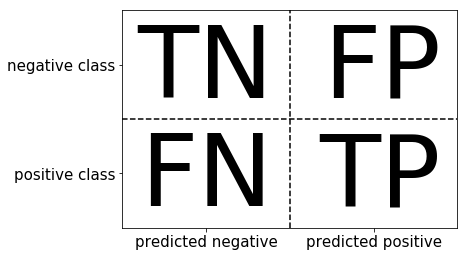

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

logreg = LogisticRegression(C=0.1, solver="lbfgs", max_iter=300).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)

# 混合行列
print(f"dummy: \n{confusion_matrix(y_test, pred_dummy)}")
print(f"logreg: \n{confusion_matrix(y_test, pred_logreg)}")

# 縦軸が答え、横軸が予測
mglearn.plots.plot_binary_confusion_matrix()

## F値による評価
f値は偏ったデータセットに対しては精度よりも良い指標になる。

* **精度**: Accuracy。陽性陰性の的中率
* **適合率** : Precision。陽性と予測した中での的中率
* **再現率** : Recall。本当の陽性の中での陽性予測率

$$
\begin{align}
    Accuracy &= \frac{TP + TN}{TP + TN + FP + FN} \\
    Precision &= \frac{TP}{TP + FP} \\
    Recall &= \frac{TP}{TP + FN} \\
    f &= \frac{Precision \times Recall}{Precision + Recall}
\end{align}
$$

In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("f1 score (dummy): {:.2}".format(f1_score(y_test, pred_dummy)))
print("f1 score (logistic regression): {:.2}".format(f1_score(y_test, pred_logreg)))

f1 score (dummy): 0.091
f1 score (logistic regression): 0.92


各指標をまとめて出す関数がある。これを使うと良い。  
横向きに適合率、再現率、F1, 支持度 (実際の所属データ数)となっている。

In [43]:
from sklearn.metrics import classification_report

print("dummy")
print(classification_report(y_test, pred_dummy, target_names=["not nine", "nine"]))

print("logreg")
print(classification_report(y_test, pred_logreg, target_names=["not nine", "nine"]))

dummy
              precision    recall  f1-score   support

    not nine       0.89      0.91      0.90       403
        nine       0.10      0.09      0.09        47

   micro avg       0.82      0.82      0.82       450
   macro avg       0.50      0.50      0.50       450
weighted avg       0.81      0.82      0.82       450

logreg
              precision    recall  f1-score   support

    not nine       0.99      1.00      0.99       403
        nine       0.98      0.87      0.92        47

   micro avg       0.98      0.98      0.98       450
   macro avg       0.98      0.93      0.96       450
weighted avg       0.98      0.98      0.98       450



## 適合率-再現率カーブ
適合率と再現率が共に高いのが良いモデルだが、トレード・オフの関係はある。decision_function の出力と閾値の調整によって、推論時にこれらを実装要件に合わせて閾値を求め使用することも可能。

以下のデータでは閾値0で適合率: 64% 、再現率: 66%を達成する事が分かる。

              precision    recall  f1-score   support

           a       0.96      0.96      0.96      1004
           b       0.64      0.67      0.66       121

   micro avg       0.92      0.92      0.92      1125
   macro avg       0.80      0.81      0.81      1125
weighted avg       0.93      0.92      0.93      1125

0.925037037037037
0.9244444444444444


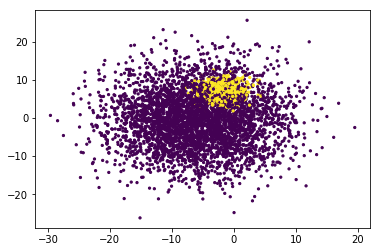

In [195]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

X, y = datasets.make_blobs(n_samples=(4000, 500), cluster_std=[7, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
plt.scatter(*X.T, c=y, s=5)

svc = SVC(gamma=0.05).fit(X_train, y_train)
print(classification_report(y_test, svc.predict(X_test), target_names=["a", "b"]))
print(svc.score(X_train, y_train))
print(svc.score(X_test, y_test))

In [45]:
rfs = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)
print(classification_report(y_test, rfs.predict(X_test), target_names=["a", "b"]))
print(rfs.score(X_train, y_train))
print(rfs.score(X_test, y_test))

              precision    recall  f1-score   support

           a       0.95      0.95      0.95      1004
           b       0.61      0.60      0.60       121

   micro avg       0.92      0.92      0.92      1125
   macro avg       0.78      0.77      0.78      1125
weighted avg       0.91      0.92      0.92      1125

1.0
0.9155555555555556


ランダムフォレストと特性を比較してみる。適合率や再現率に高い値が求められる場合にランダムフォレストの方が良い精度が出ていることが分かる。

In [46]:
from sklearn.metrics import precision_recall_curve

precisionA, recallA, thresholdsA = \
    precision_recall_curve(y_test, svc.decision_function(X_test))

precisionB, recallB, thresholdsB = \
    precision_recall_curve(y_test, rfs.predict_proba(X_test)[:,1])

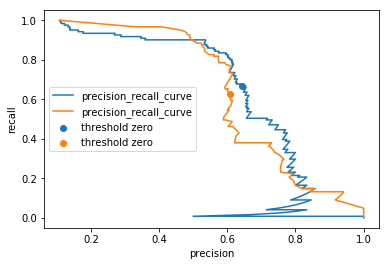

In [47]:
close_zero = np.argmin(np.abs(thresholdsA))
plt.plot(precisionA, recallA, label="precision_recall_curve")
plt.scatter(precisionA[close_zero], recallA[close_zero], label="threshold zero")

close_zero = np.argmin(np.abs(thresholdsB - 0.5))
plt.plot(precisionB, recallB, label="precision_recall_curve")
plt.scatter(precisionB[close_zero], recallB[close_zero], label="threshold zero")

plt.xlabel("precision")
plt.ylabel("recall")
plt.legend()

In [54]:
recall_copy = np.copy(recallA)
recall_copy[precisionA < 0.6] = 0
threshold2 = np.argmax(recall_copy)

print(f"threshold: \t{thresholdsA[threshold2]}")
print(f"precision: \t{precisionA[threshold2]}")
print(f"recall: \t{recallA[threshold2]}")

threshold: 	-0.5415065079285716
precision: 	0.6024096385542169
recall: 	0.8264462809917356


適合率-再現率カーブの面積を出すと平均的な性能の良し悪しを定量評価できる。

In [55]:
from sklearn.metrics import average_precision_score

ap_rfs = average_precision_score(y_test, rfs.predict_proba(X_test)[:,1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))
print(f"Average precision of random forest: {ap_rfs:.3f}")
print(f"Average precision of svc: {ap_svc:.3f}")

Average precision of random forest: 0.661
Average precision of svc: 0.666


## ROCカーブ、ROC AUC

ROC AUC: 0.9162935036712654


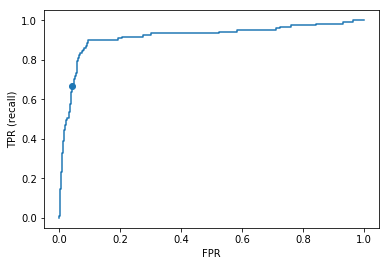

In [110]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

close_zero = np.argmin(np.abs(thresholds))
plt.scatter(fpr[close_zero], tpr[close_zero])

# 適合率-再現率カーブの面積と同様のものをROCカーブでも導出可能
print(f"ROC AUC: {roc_auc_score(y_test, svc.decision_function(X_test))}")

## 交差検定やグリッドサーチへの適用

GridSearchCV, cross_val_score には scoring 引数で正解率 (accuracy) の代わりに ROC_AUC を指定することも可能。偏りのあるデータの分類に対しては正解率よりもROC_AUCの方が向いている。その他の指定可能な評価方法は [Model evaluation: quantifying the quality of predictions](https://scikit-learn.org/stable/modules/model_evaluation.html) に載っている。

In [214]:
from sklearn.preprocessing import OneHotEncoder

X = MinMaxScaler().fit_transform(digits.data)
y = digits.target == 9
# y = OneHotEncoder(categories='auto').fit_transform(digits.target.reshape(-1, 1)).toarray()

logreg = LogisticRegression(solver="lbfgs", max_iter=800, multi_class="auto")
dummy = DummyClassifier(strategy="most_frequent", random_state=0)

print("accuracy")
print(cross_val_score(logreg, X=X, y=y, cv=2))
print(cross_val_score(dummy, X=X, y=y, cv=2))

print("\nroc_auc")
print(cross_val_score(logreg, X=X, y=y, cv=2, scoring="roc_auc"))
print(cross_val_score(dummy, X=X, y=y, cv=2, scoring="roc_auc"))

accuracy
[0.95661846 0.97327394]
[0.89988877 0.89977728]

roc_auc
[0.99035847 0.98411716]
[0.5 0.5]
